In [ ]:
import ee
import sys
import os
base_path = 'c:\\Users\\ishaa\\OneDrive\\Desktop\\DataLab\\Syria\\syria-economic-monitor'
phenolopy_module_path = os.path.join(base_path,'Phenolopy','scripts')
gee_zonal_module_path = os.path.join(base_path,'GEE_Zonal','src','gee_zonal')
sys.path.append(phenolopy_module_path)
sys.path.append(gee_zonal_module_path)

import phenolopy
import zarr
import rioxarray
import requests
import geopandas as gpd
import pandas as pd
import numpy as np 
import json
import gee_helpers
from gee_helpers import gpd_to_gee
import json
import xarray as xr
import zarr
import xee
from rasterstats import zonal_stats

from tqdm.notebook import tqdm
from dask.distributed import Client, LocalCluster
import requests

from geemap.conversion import *

from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [6]:
ee.Authenticate()
ee.Initialize()

In [7]:
base_path = "C:\\Users\\ishaa\\OneDrive\\Desktop\\DataLab\\Syria\\syria-economic-monitor"

In [11]:
start_period = ee.Date("2004-01-01")
end_period = ee.Date("2024-09-30")

terra = (
    ee.ImageCollection("MODIS/061/MOD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_period, end_period)
)
aqua = (
    ee.ImageCollection("MODIS/061/MYD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_period, end_period)
)

modis = terra.select("EVI").merge(aqua.select("EVI"))
modis = modis.sort("system:time_start")


def bitwiseExtract(value, fromBit, toBit=None):
    if toBit == None:
        toBit = fromBit
    maskSize = ee.Number(1).add(toBit).subtract(fromBit)
    mask = ee.Number(1).leftShift(maskSize).subtract(1)
    return value.rightShift(fromBit).bitwiseAnd(mask)


# Applying the SummaryQA  and DetailedQA
def modisQA_mask(image):
    sqa = image.select("SummaryQA")
    dqa = image.select("DetailedQA")
    viQualityFlagsS = bitwiseExtract(sqa, 0, 1)
    viQualityFlagsD = bitwiseExtract(dqa, 0, 1)
    # viUsefulnessFlagsD = bitwiseExtract(dqa, 2, 5)
    viSnowIceFlagsD = bitwiseExtract(dqa, 14)
    viShadowFlagsD = bitwiseExtract(dqa, 15)
    # Good data, use with confidence
    mask = (
        viQualityFlagsS.eq(0)
        .And(viQualityFlagsD.eq(0))
        .And(viQualityFlagsS.eq(1))
        .And(viQualityFlagsD.eq(1))
        .And(viSnowIceFlagsD)
        .eq(0)
    )
    # .And(viShadowFlagsD).eq(0); # No shadow
    return image.updateMask(mask)


mod13q1_QC = terra.map(modisQA_mask)
myd13q1_QC = aqua.map(modisQA_mask)

mxd13q1_cleaned = mod13q1_QC.select("EVI").merge(myd13q1_QC.select("EVI"))
mxd13q1_cleaned_sorted = mxd13q1_cleaned.sort("system:time_start")

bool_dict = {
    "0": "ocean",
    "1": "non_crop",
    "2": "crop_irrigated",
    "3": "crop_rainfed",
}

lgrip30 = ee.ImageCollection(
    "projects/sat-io/open-datasets/GFSAD/LGRIP30"
).mosaic()  # .clip(geoj)
crop_data = lgrip30.select("b1").gt(1).rename("crop")

# Use ESA WorldCover 2021 dataset for the crop mask
esa_worldcover = ee.ImageCollection("ESA/WorldCover/v100").mosaic()
crop_data1 = esa_worldcover.select("Map").eq(40).rename("crop")


In [15]:
iso3 = "SYR"
country = "Syria"
release_type = "gbOpen"

adm = "ADM0"
geo_url = f"https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/"
res = requests.get(geo_url).json()
print("Reading " + res["gjDownloadURL"])
adm0_syr = gpd.read_file(res["gjDownloadURL"])

adm = "ADM1"
geo_url = f"https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/"
res = requests.get(geo_url).json()
print("Reading " + res["gjDownloadURL"])
adm1_syr = gpd.read_file(res["gjDownloadURL"])

adm = "ADM2"
geo_url = f"https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/"
res = requests.get(geo_url).json()
print("Reading " + res["gjDownloadURL"])
adm2_syr = gpd.read_file(res["gjDownloadURL"])


Reading https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/SYR/ADM0/geoBoundaries-SYR-ADM0.geojson
Reading https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/SYR/ADM1/geoBoundaries-SYR-ADM1.geojson
Reading https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/SYR/ADM2/geoBoundaries-SYR-ADM2.geojson


In [16]:
'''import requests
test_url = "https://www.google.com"
res = requests.get(test_url)
print(res.status_code)'''


'import requests\ntest_url = "https://www.google.com"\nres = requests.get(test_url)\nprint(res.status_code)'

In [19]:
aoi = gpd_to_gee(adm0_syr)
## considering smaller aoi geometry
aoi1 = gpd_to_gee(adm1_syr)
aoi2 = gpd_to_gee( adm2_syr)

In [25]:
syr_admin0_path = os.path.join(base_path,'data\\boundaries\\syr_admin0.shp')
import geemap

#syr_admin0_path = 'syr_admin0.shp'
syr_shp = gpd.read_file(syr_admin0_path)
syr_shp.to_file("syria_boundary.geojson", driver="GeoJSON")

with open("syria_boundary.geojson") as f:
    syr_geojson = json.load(f)

syr_geometry = ee.Geometry(syr_geojson['features'][0]['geometry'])

In [20]:
# Create a map centered on Syria
m = geemap.Map(center=[34.8, 39.1], zoom=6)  # Adjust the center and zoom for Syria

# Add the syr_geometry to the map
m.addLayer(syr_geometry, {'color': 'blue'}, 'Syria Boundary')

# Display the map
m


Map(center=[34.8, 39.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [26]:
aoi = gpd_to_gee(syr_shp)

In [22]:
scale_factor = 0.0001


# apply cropland mask to imageCollection
# def cropmask(img):
#   return img.clip(aoi) #.multiply(scale_factor) # unmask(-1)
def cropmask(img):
    return img.updateMask(crop_data).clip(aoi)  # .multiply(scale_factor) # unmask(-1)


#mxd13q1 = mxd13q1_cleaned_sorted.map(cropmask)
mxd13q1 = modis.map(cropmask)

In [23]:
#ee.Initialize(opt_url="https://earthengine-highvolume.googleapis.com")

In [24]:
utm = 'EPSG:32636'# 'EPSG:4326' #"EPSG:32632"  #'EPSG:4326' 'SR-ORG:6974' 'EPSG:23847'

In [27]:
'''missing_images = []

# Loop over the years and months to find missing data
for year in range(2010, 2025):
    for month in range(1, 13):
        # Filter the collection for the specified year and month
        modis_sel = modis.filter(ee.Filter.calendarRange(year, year, "year")).filter(
            ee.Filter.calendarRange(month, month, "month")
        )
        
        # Check if the collection has images
        if modis_sel.size().getInfo() == 0:
            missing_images.append((year, month))
            print(f"No images found for {year}-{month}")

# Display the years and months with missing images
if missing_images:
    print("The following year-month combinations have missing images:")
    for year, month in missing_images:
        print(f"{year}-{month:02d}")
else:
    print("No missing images found in the given range.")'''


'missing_images = []\n\n# Loop over the years and months to find missing data\nfor year in range(2010, 2025):\n    for month in range(1, 13):\n        # Filter the collection for the specified year and month\n        modis_sel = modis.filter(ee.Filter.calendarRange(year, year, "year")).filter(\n            ee.Filter.calendarRange(month, month, "month")\n        )\n        \n        # Check if the collection has images\n        if modis_sel.size().getInfo() == 0:\n            missing_images.append((year, month))\n            print(f"No images found for {year}-{month}")\n\n# Display the years and months with missing images\nif missing_images:\n    print("The following year-month combinations have missing images:")\n    for year, month in missing_images:\n        print(f"{year}-{month:02d}")\nelse:\n    print("No missing images found in the given range.")'

In [25]:
ds_all = []
scale_factor = 0.0001
years = range(2010, 2025)
months = range(1, 13)

for year in tqdm(years):
    for month in tqdm(months):
        # Stop iterating after September 2024
        if year == 2024 and month > 9:
            break
        
        modis_sel = modis.filter(ee.Filter.calendarRange(year, year, "year")).filter(
            ee.Filter.calendarRange(month, month, "month")
        )
        
        if modis_sel.size().getInfo() > 0:
            ds = xr.open_dataset(
                modis_sel,
                engine="ee",
                geometry=syr_geometry,
                crs=utm,
                scale=250,
            )
            ds = ds * scale_factor
            ds = ds.compute()
            ds_all.append(ds)
        else:
            print(f"No data for {year}-{month:02d}")

print("Processing complete.")


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Processing complete.


In [22]:
ds = xr.concat(ds_all, dim="time")

In [21]:
print(ds)

<xarray.Dataset> Size: 15GB
Dimensions:  (time: 679, X: 2346, Y: 2373)
Coordinates:
  * time     (time) datetime64[ns] 5kB 2010-01-01 2010-01-09 ... 2024-09-29
  * X        (X) float64 19kB 7.462e+05 7.465e+05 ... 1.332e+06 1.332e+06
  * Y        (Y) float64 19kB 3.579e+06 3.579e+06 ... 4.171e+06 4.172e+06
Data variables:
    EVI      (time, X, Y) float32 15GB 0.2684 0.2332 0.2292 ... 0.0912 0.0939
Attributes:
    crs:      EPSG:32636


In [ ]:
#import xarray as xr

# Assuming your dataset is already loaded as 'ds'
# Total number of data points in the EVI variable
total_values = ds['EVI'].size

# Number of non-NaN values in the EVI variable
non_nan_count = ds['EVI'].notnull().sum().values

# Calculate the percentage of non-NaN values
percentage_non_nan = (non_nan_count / total_values) * 100

# Print the result
print(f"Percentage of non-NaN values in the EVI column: {percentage_non_nan:.2f}%")


In [23]:
ds = ds.isel(Y=slice(None, None, -1))

In [24]:
for val in ds['EVI']:
    print(val.values)

[[0.2364     0.17629999 0.1677     ... 0.22919999 0.2332     0.26839998]
 [0.2364     0.2561     0.2561     ... 0.29639998 0.2507     0.23169999]
 [0.2986     0.2561     0.2561     ... 0.3127     0.3748     0.25239998]
 ...
 [0.2899     0.2676     0.2811     ... 0.0993     0.1021     0.1041    ]
 [0.2899     0.2809     0.3619     ... 0.0986     0.1013     0.1023    ]
 [0.27879998 0.3005     0.3023     ... 0.1065     0.1013     0.10349999]]
[[0.1504     0.1504     0.1326     ... 0.2454     0.28689998 0.3073    ]
 [0.1504     0.1326     0.1326     ... 0.2976     0.306      0.3073    ]
 [0.1758     0.1595     0.14029999 ... 0.3293     0.3285     0.33879998]
 ...
 [0.2757     0.2782     0.2572     ... 0.1042     0.1046     0.1059    ]
 [0.28939998 0.27429998 0.2969     ... 0.1052     0.1029     0.1076    ]
 [0.2873     0.3082     0.3234     ... 0.1033     0.1042     0.1077    ]]
[[0.1859     0.1742     0.236      ... 0.235      0.3172     0.333     ]
 [0.2386     0.23719999 0.23719999 ... 

In [25]:
ds.to_netcdf('syr_geom_nonbit_masked_2020_2023.nc')

In [41]:
netcdf_path = 'syr_geom_bit_masked_2010_2024.nc'
ds = xr.open_dataset(netcdf_path)  # maradi
# ds = ds.isel(time=range(0,23))

In [42]:
ds

<xarray.Dataset> Size: 15GB
Dimensions:  (time: 679, X: 2346, Y: 2373)
Coordinates:
  * time     (time) datetime64[ns] 5kB 2010-01-01 2010-01-09 ... 2024-09-29
  * X        (X) float64 19kB 7.462e+05 7.465e+05 ... 1.332e+06 1.332e+06
  * Y        (Y) float64 19kB 4.172e+06 4.171e+06 ... 3.579e+06 3.579e+06
Data variables:
    EVI      (time, X, Y) float32 15GB ...
Attributes:
    crs:      EPSG:32636

In [28]:
import multiprocessing
multiprocessing.cpu_count()

32

In [29]:
# Let's start simple with a LocalCluster that makes use of all the cores and RAM we have on a single machine
# cluster = LocalCluster()
# explicitly connect to the cluster we just created
# client = Client(cluster)
# client

# Dask Prep
workers = 70  # 50
cluster = LocalCluster(n_workers=workers)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 70
Total threads: 70,Total memory: 124.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45153,Workers: 70
Dashboard: http://127.0.0.1:8787/status,Total threads: 70
Started: Just now,Total memory: 124.35 GiB
Comm: tcp://127.0.0.1:39563,Total threads: 1
Dashboard: http://127.0.0.1:33919/status,Memory: 1.78 GiB
Nanny: tcp://127.0.0.1:38817,


2024-11-03 21:16:59,550 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:37761 (pid=6817) exceeded 95% memory budget. Restarting...
2024-11-03 21:16:59,683 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:37761' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('getitem-c8f761d820e6ecf967943ddd823e8b31', 0, 0, 1.1), ('getitem-c8f761d820e6ecf967943ddd823e8b31', 0, 0.9, 2), ('getitem-c8f761d820e6ecf967943ddd823e8b31', 0.9, 0, 2.9), ('getitem-c8f761d820e6ecf967943ddd823e8b31', 0, 0, 2), ('getitem-c8f761d820e6ecf967943ddd823e8b31', 0.9, 0, 1.1), ('getitem-c8f761d820e6ecf967943ddd823e8b31', 0.9, 0.9, 2.9), ('getitem-c8f761d820e6ecf967943ddd823e8b31', 0, 0.9, 2.9), ('getitem-c8f761d820e6ecf967943ddd823e8b31', 0.9, 0, 2), ('getitem-c8f761d820e6ecf967943ddd823e8b31', 0, 0.9, 1.1), ('getitem-c8f761d820e6ecf967943ddd823e8b31', 0, 0, 2.9), ('getitem-c8f761d820e6ecf967943ddd823e8b31', 0.9, 0.9, 1.1), ('getitem-c8f761d820e6ec

In [ ]:
ds_all = []
years = range(2022, 2023)  
for year in tqdm(years):
    ds_sel = ds.sel(time=ds.time.dt.year == year)
    dask_chunks = {"time": -1, "X": 250, "Y": 250}
    ds_sel = ds_sel.chunk(dask_chunks)
    ds_sel = ds_sel.rename_vars({"EVI": "veg_index"})
    ds_sel = phenolopy.remove_outliers(
        ds=ds_sel, method="median", user_factor=2, z_pval=0.05
    )
    ds_sel = ds_sel.chunk(dask_chunks)
    ds_sel = phenolopy.interpolate(ds=ds_sel, method="interpolate_na")
    ds_sel = phenolopy.smooth(
        ds=ds_sel, method="savitsky", window_length=3, polyorder=1
    )
    ds_sel = ds_sel.compute()
    ds_all.append(ds_sel)
    print(f"Finished {year}")

In [43]:
ds_all = []
scale_factor = 0.0001
years = range(2010, 2025)
months = range(1, 13)

for year in tqdm(years):
    for month in tqdm(months):
        # Stop iterating after September 2024
        if year == 2024 and month > 9:
            break
        
        modis_sel = modis.filter(ee.Filter.calendarRange(year, year, "year")).filter(
            ee.Filter.calendarRange(month, month, "month")
        )
        
        if modis_sel.size().getInfo() > 0:
            try:
                # Break processing into smaller chunks by processing one month at a time
                ds = xr.open_dataset(
                    modis_sel,
                    engine="ee",
                    geometry=syr_geometry,
                    crs=utm,
                    scale=250,
                )
                ds = ds * scale_factor
                
                # Check if 'EVI' exists in the dataset
                if 'EVI' in ds.data_vars:
                    ds = ds.rename_vars({"EVI": "veg_index"})
                else:
                    print(f"'EVI' not found in dataset for {year}-{month:02d}")
                    continue  # Skip processing if 'EVI' is not found

                # Chunk the dataset into smaller parts
                dask_chunks = {"time": -1, "X": 250, "Y": 250}
                ds = ds.chunk(dask_chunks)

                # Apply necessary processing steps in smaller pieces
                ds = phenolopy.remove_outliers(ds=ds, method="median", user_factor=2, z_pval=0.05)
                ds = ds.chunk(dask_chunks)
                ds = phenolopy.interpolate(ds=ds, method="interpolate_na")
                ds = phenolopy.smooth(ds=ds, method="savitsky", window_length=3, polyorder=1)
                
                # Compute the result
                ds = ds.compute()
                
                ds_all.append(ds)
                print(f"Finished {year}-{month:02d}")
            except Exception as e:
                print(f"Error processing {year}-{month:02d}: {e}")
        else:
            print(f"No data for {year}-{month:02d}")

print("Processing complete.")


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python

Finished 2010-01
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python

Finished 2010-02
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python

Finished 2010-03
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python

Finished 2010-04
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
/opt/conda/lib/python3.10/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


Finished 2010-05
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Finished 2010-06
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.10/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


Finished 2010-07
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2010-08
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.10/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


Finished 2010-09
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Finished 2010-10
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Finished 2010-11
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2010-12


  0%|          | 0/12 [00:00<?, ?it/s]

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2011-01
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2011-02
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2011-03
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2011-04
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Finished 2011-05
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2011-06
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Finished 2011-07
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2011-08
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).


/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2011-09
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2011-10
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2011-11
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2011-12


  0%|          | 0/12 [00:00<?, ?it/s]

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2012-01
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2012-02
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2012-03
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).


/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2012-04
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2012-05
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2012-06
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2012-07
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2012-08
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2012-09
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2012-10
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2012-11
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2012-12


  0%|          | 0/12 [00:00<?, ?it/s]

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2013-01
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).


/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2013-02
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2013-03
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2013-04
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2013-05
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2013-06
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2013-07
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2013-08
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2013-09
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2013-10
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Finished 2013-11
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2013-12


  0%|          | 0/12 [00:00<?, ?it/s]

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2014-01
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2014-02
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2014-03
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2014-04
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2014-05
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2014-06
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2014-07
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2014-08
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2014-09
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2014-10
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2014-11
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2014-12


  0%|          | 0/12 [00:00<?, ?it/s]

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2015-01
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2015-02
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2015-03
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2015-04
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2015-05
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2015-06
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2015-07
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2015-08
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2015-09
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2015-10
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2015-11
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2015-12


  0%|          | 0/12 [00:00<?, ?it/s]

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2016-01
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
/opt/conda/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Finished 2016-02
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.


/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2016-03
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2016-04
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2016-05
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2016-06
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2016-07
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2016-08
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2016-09
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2016-10
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2016-11
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2016-12


  0%|          | 0/12 [00:00<?, ?it/s]

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2017-01
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2017-02
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2017-03
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2017-04
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2017-05
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2017-06
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2017-07
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2017-08
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2017-09
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2017-10
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2017-11
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2017-12


  0%|          | 0/12 [00:00<?, ?it/s]

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2018-01
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2018-02
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2018-03
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2018-04
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2018-05
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2018-06
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2018-07
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2018-08
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2018-09
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2018-10
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2018-11
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2018-12


  0%|          | 0/12 [00:00<?, ?it/s]

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2019-01
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2019-02
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2019-03
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2019-04
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2019-05
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2019-06
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2019-07
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2019-08
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2019-09
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2019-10
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2019-11
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2019-12


  0%|          | 0/12 [00:00<?, ?it/s]

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2020-01
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2020-02
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2020-03
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2020-04
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2020-05
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2020-06
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2020-07
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2020-08
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2020-09
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2020-10
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2020-11
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2020-12


  0%|          | 0/12 [00:00<?, ?it/s]

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2021-01
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2021-02
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2021-03
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2021-04
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2021-05
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2021-06
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2021-07
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2021-08
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2021-09
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2021-10
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2021-11
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2021-12


  0%|          | 0/12 [00:00<?, ?it/s]

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2022-01
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2022-02
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2022-03
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2022-04
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2022-05
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2022-06
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2022-07
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2022-08
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2022-09
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2022-10
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2022-11
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2022-12


  0%|          | 0/12 [00:00<?, ?it/s]

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2023-01
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2023-02
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2023-03
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2023-04
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2023-05
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2023-06
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2023-07
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2023-08
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2023-09
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2023-10
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2023-11
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2023-12


  0%|          | 0/12 [00:00<?, ?it/s]

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2024-01
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2024-02
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2024-03
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2024-04
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 64.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2024-05
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2024-06
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2024-07
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2024-08
Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



/opt/conda/lib/python3.10/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/conda/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 85.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


Finished 2024-09
Processing complete.


In [44]:
print(ds_all)

[<xarray.Dataset> Size: 89MB
Dimensions:    (time: 4, X: 2346, Y: 2373)
Coordinates:
  * time       (time) datetime64[ns] 32B 2010-01-01 2010-01-09 ... 2010-01-25
  * X          (X) float64 19kB 7.462e+05 7.465e+05 ... 1.332e+06 1.332e+06
  * Y          (Y) float64 19kB 3.579e+06 3.579e+06 ... 4.171e+06 4.172e+06
Data variables:
    veg_index  (time, X, Y) float32 89MB 0.2706 0.2371 0.2336 ... 0.3519 0.3621, <xarray.Dataset> Size: 89MB
Dimensions:    (time: 4, X: 2346, Y: 2373)
Coordinates:
  * time       (time) datetime64[ns] 32B 2010-02-02 2010-02-10 ... 2010-02-26
  * X          (X) float64 19kB 7.462e+05 7.465e+05 ... 1.332e+06 1.332e+06
  * Y          (Y) float64 19kB 3.579e+06 3.579e+06 ... 4.171e+06 4.172e+06
Data variables:
    veg_index  (time, X, Y) float32 89MB 0.2833 0.2861 0.2435 ... 0.4519 0.4073, <xarray.Dataset> Size: 89MB
Dimensions:    (time: 4, X: 2346, Y: 2373)
Coordinates:
  * time       (time) datetime64[ns] 32B 2010-03-06 2010-03-14 ... 2010-03-30
  * X          

In [45]:
len(ds_all)

177

In [46]:
ds2 = xr.concat(ds_all, dim="time")

In [50]:
ds2.to_netcdf('syr_evi_savitsky_processed_2010_2025.nc')

In [30]:
import xarray
import rioxarray
import zarr

In [31]:
import xee

In [30]:
#pip list

In [26]:
# Flip the data along the y-axis
# ds2 = ds2.isel(Y=slice(None, None, -1))
ds_geo = ds2.copy()
ds_geo.rio.write_crs(utm, inplace=True)
ds_geo = ds_geo.transpose("time", "Y", "X")
ds_geo = ds_geo.rename({"Y": "y", "X": "x"})
ds_geo.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
ds_geo.to_zarr("modis_crop_processed_2010_2025.zarr")

ContainsGroupError: path '' contains a group

In [32]:
ds_geo = xr.open_zarr("modis_crop_processed_2010_2025.zarr")
ds_geo

<xarray.Dataset> Size: 15GB
Dimensions:      (time: 679, y: 2373, x: 2346)
Coordinates:
    spatial_ref  int64 8B ...
  * time         (time) datetime64[ns] 5kB 2010-01-01 2010-01-09 ... 2024-09-29
  * x            (x) float64 19kB 7.462e+05 7.465e+05 ... 1.332e+06 1.332e+06
  * y            (y) float64 19kB 3.579e+06 3.579e+06 ... 4.171e+06 4.172e+06
Data variables:
    veg_index    (time, y, x) float32 15GB dask.array<chunksize=(43, 149, 147), meta=np.ndarray>

In [23]:
!pip show zarr

Name: zarr
Version: 2.18.3
Summary: An implementation of chunked, compressed, N-dimensional arrays for Python
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /opt/conda/lib/python3.10/site-packages
Requires: asciitree, fasteners, numcodecs, numpy
Required-by: 


In [24]:
!pip show xarray

Name: xarray
Version: 2024.10.0
Summary: N-D labeled arrays and datasets in Python
Home-page: 
Author: 
Author-email: xarray Developers <xarray@googlegroups.com>
License: Apache-2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: numpy, packaging, pandas
Required-by: datacube, xee


In [25]:
!pip install xarray==2024.7.0

  Using cached xarray-2024.7.0-py3-none-any.whl.metadata (11 kB)
Using cached xarray-2024.7.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: xarray
    Found existing installation: xarray 2024.10.0
    Uninstalling xarray-2024.10.0:
      Successfully uninstalled xarray-2024.10.0


In [26]:
!pip install zarr==2.18.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.2/210.2 kB 2.3 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: zarr
    Found existing installation: zarr 2.18.3
    Uninstalling zarr-2.18.3:
      Successfully uninstalled zarr-2.18.3


## Anomalies per Pixel

In [33]:
ds_monthly = ds_geo.resample(time="1ME").mean()

In [34]:
start_reference = "2010-01-01"
end_reference = "2022-12-31"

In [35]:
ds_ref = ds_monthly.sel(time=slice(None, end_reference))  # ds_geo
ds_filt = ds_monthly.sel(time=ds_monthly.time.dt.year == 2024)

ds_2024_03 = ds_filt.sel(time=ds_filt.time.dt.month == 3).isel(time=0)
ds_ref_01_mean = ds_ref.sel(time=ds_ref.time.dt.month == 3).mean(dim="time")
ds_ref_01_sdt = ds_ref.sel(time=ds_ref.time.dt.month == 3).std(dim="time")

ds_diff = ds_2024_03 - ds_ref_01_mean
ds_zscore = ds_diff / ds_ref_01_sdt

In [36]:
ds_zscore = ds_zscore.compute()

In [37]:
print(ds_zscore)

<xarray.Dataset> Size: 22MB
Dimensions:      (x: 2346, y: 2373)
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 19kB 7.462e+05 7.465e+05 ... 1.332e+06 1.332e+06
  * y            (y) float64 19kB 3.579e+06 3.579e+06 ... 4.171e+06 4.172e+06
    time         datetime64[ns] 8B 2024-03-31
Data variables:
    veg_index    (y, x) float32 22MB 1.253 1.404 1.438 ... 0.53 -0.3536 0.6749


In [38]:
ds_zscore["veg_index"].rio.write_nodata(np.nan, inplace=True)
ds_zscore["veg_index"].rio.to_raster("zcore_syr_2024_03.tif")

In [43]:
!pip install leafmap -q

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


In [44]:
# import leafmap
import leafmap.foliumap as leafmap

import rasterio
import xarray as xr

In [ ]:
url1 = "https://open.gishub.org/data/raster/landsat.tif"
url2 = "https://open.gishub.org/data/raster/srtm90.tif"
satellite = leafmap.download_file(url1, "landsat.tif", overwrite=True)
dem = leafmap.download_file(url2, "srtm90.tif")

In [38]:
dataset = rasterio.open(satellite)
nir = dataset.read(4).astype(float)
red = dataset.read(1).astype(float)
ndvi = (nir - red) / (nir + red)

In [39]:
ndvi_image = leafmap.array_to_image(ndvi, source=satellite)

In [40]:
ndvi_image.profile

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 2127, 'height': 1564, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(180.0, 0.0, -13442580.0,
       0.0, -180.0, 4670100.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [56]:
!pip install localtileserver -q

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 41.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 25.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.5/265.5 kB 3.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 783.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 718.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.4/186.4 kB 2.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.1 MB/s eta 0:00:00eta 0:00:01


In [57]:
import localtileserver
print(localtileserver.Report())


--------------------------------------------------------------------------------
  Date: Mon Nov 04 00:57:51 2024 UTC

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 32
           Machine : x86_64
      Architecture : 64bit
               RAM : 124.3 GiB
       Environment : Jupyter

  Python 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:36:39) [GCC
  10.4.0]

   localtileserver : 0.10.5
             click : 8.1.7
             flask : 2.3.3
     flask_caching : 2.3.0
        flask_cors : 5.0.0
       flask_restx : 1.3.0
             numpy : 1.26.4
          rasterio : 1.4.2
         rio_cogeo : 5.3.6
         rio_tiler : 7.1.0
     server_thread : 0.2.0
          werkzeug : 2.3.8
            folium : 0.17.0
        ipyleaflet : 0.19.2
        jupyterlab : 4.1.6
        matplotlib : 3.8.4
           shapely : 2.0.6
         traitlets : 5.14.3
--------------------------------------------------------------------------------


In [ ]:
'''m = leafmap.Map()
m.add_raster(satellite, indexes=[4, 1, 2], vmin=0, vmax=120, layer_name="Landsat 7")
m.add_raster(ndvi_image, colormap="Greens", layer_name="NDVI")
m'''

In [40]:
ds_ref = ds_monthly.sel(time=slice(None, end_reference)) # ds_geo
ds_filt = ds_monthly.sel(time=ds_monthly.time.dt.year==2024)
ds_2024_03 = ds_filt.sel(time=ds_filt.time.dt.month==3).isel(time=0)
ds_ref_03 = ds_ref.sel(time=ds_ref.time.dt.month==3).mean(dim='time')
ds_diff = ds_2024_03 - ds_ref_03
ds_pct_ch = (ds_diff / ds_ref_03)

In [41]:
ds_pct_ch = ds_pct_ch.compute()

In [42]:
ds_pct_ch['veg_index'].rio.write_nodata(np.nan, inplace=True)

<xarray.DataArray 'veg_index' (y: 2373, x: 2346)> Size: 22MB
array([[ 0.2205441 ,  0.24906658,  0.2385107 , ...,  0.05764229,
         0.03115563,  0.06822535],
       [ 0.22708204,  0.22779314,  0.22923286, ...,  0.02062739,
         0.04503947,  0.01687622],
       [ 0.2442546 ,  0.3359016 ,  0.28409263, ...,  0.023477  ,
         0.03310724,  0.0272421 ],
       ...,
       [ 0.10689032,  0.08775088, -0.07289401, ...,  0.09070577,
         0.15149619,  0.292546  ],
       [ 0.06300554,  0.0322095 ,  0.05004136, ..., -0.01174546,
        -0.04563829,  0.3004057 ],
       [ 0.06704104,  0.102197  ,  0.04741364, ...,  0.08069641,
        -0.05631175,  0.10443503]], dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 19kB 7.462e+05 7.465e+05 ... 1.332e+06 1.332e+06
  * y            (y) float64 19kB 3.579e+06 3.579e+06 ... 4.171e+06 4.172e+06
    time         datetime64[ns] 8B 2024-03-31
Attributes:
    _FillValue:  nan

In [43]:
ds_pct_ch['veg_index'].rio.to_raster('pct_ch_2024_03.tif')

In [44]:
da = ds_pct_ch["veg_index"]

In [ ]:
'''m = leafmap.Map()
m.add_raster(da, colormap="BrBG", layer_name="VEG Index")
m.add_raster(dem, colormap="terrain", layer_name="DEM")
m.add_raster(masked_array, colormap="coolwarm", layer_name="Classified DEM")
m'''

In [59]:
print(ds_pct_ch["veg_index"].max())
print(ds_pct_ch["veg_index"].max())


<xarray.DataArray 'veg_index' ()> Size: 4B
array(3389.5422, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0
    time         datetime64[ns] 8B 2023-07-31
<xarray.DataArray 'veg_index' ()> Size: 4B
array(3389.5422, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0
    time         datetime64[ns] 8B 2023-07-31


## Summary of Anomalies

In [45]:
# data = ds_pct_ch['veg_index'].values
data = ds_zscore["veg_index"].values
data = data[~np.isnan(data)]

In [46]:
data = data[~np.isnan(data)]

In [47]:
# bins = np.linspace(-0.5, 0.5, 21)
# bins = range(-5, 5, 1)
# bins = np.linspace(-3, 3, 13)
bins = [-20, -2, -1, -0.5, 0.5, 1, 2, 20]
bin_labels = [
    "< -2",
    "(-2, -1]",
    "(-1, -0.5]",
    "(-0.5, -0.5]",
    "(0.5, 1]",
    "(1, 2]",
    "> 2",
]
bins

[-20, -2, -1, -0.5, 0.5, 1, 2, 20]

In [44]:
import matplotlib.pyplot as plt

In [45]:
vals, bins = np.histogram(data, bins=bins)
df = pd.DataFrame({"vals": vals, "bins": bins[:-1]})

<Axes: xlabel='bins'>

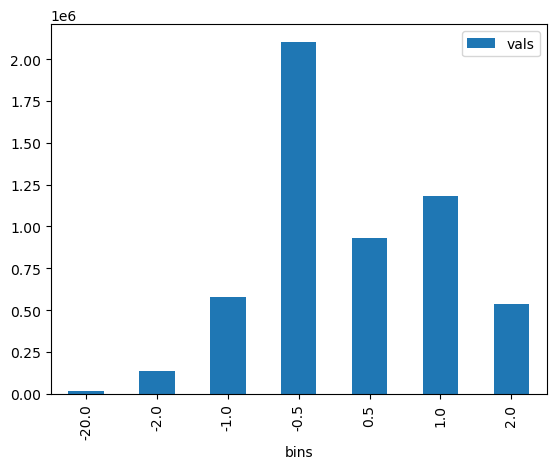

In [46]:
fig, ax = plt.subplots()
df.plot(kind="bar", x="bins", y="vals", ax=ax)

In [48]:
bins = [-20, -2, -1, -0.5, 0.5, 1, 2, 20]
bin_labels = [
    "< -2",
    "(-2, -1]",
    "(-1, -0.5]",
    "(-0.5, -0.5]",
    "(0.5, 1]",
    "(1, 2]",
    "> 2",
]

df = pd.DataFrame(data, columns=["zscore"])
df.loc[:, "zscore_bin"] = pd.cut(
    data, bins=bins, include_lowest=True, labels=bin_labels
)
df2 = df["zscore_bin"].value_counts().sort_index()
df2 = pd.DataFrame(df2).reset_index()
df2.loc[:, "pct"] = df2["count"] / df2["count"].sum()

In [49]:
font = "Liberation Sans"

In [50]:
df2

,zscore_bin,count,pct
0,< -2,15659,0.002859
1,"(-2, -1]",134176,0.024496
2,"(-1, -0.5]",577672,0.105465
3,"(-0.5, -0.5]",2103075,0.383957
4,"(0.5, 1]",931692,0.170098
5,"(1, 2]",1180113,0.215453
6,> 2,534981,0.097671


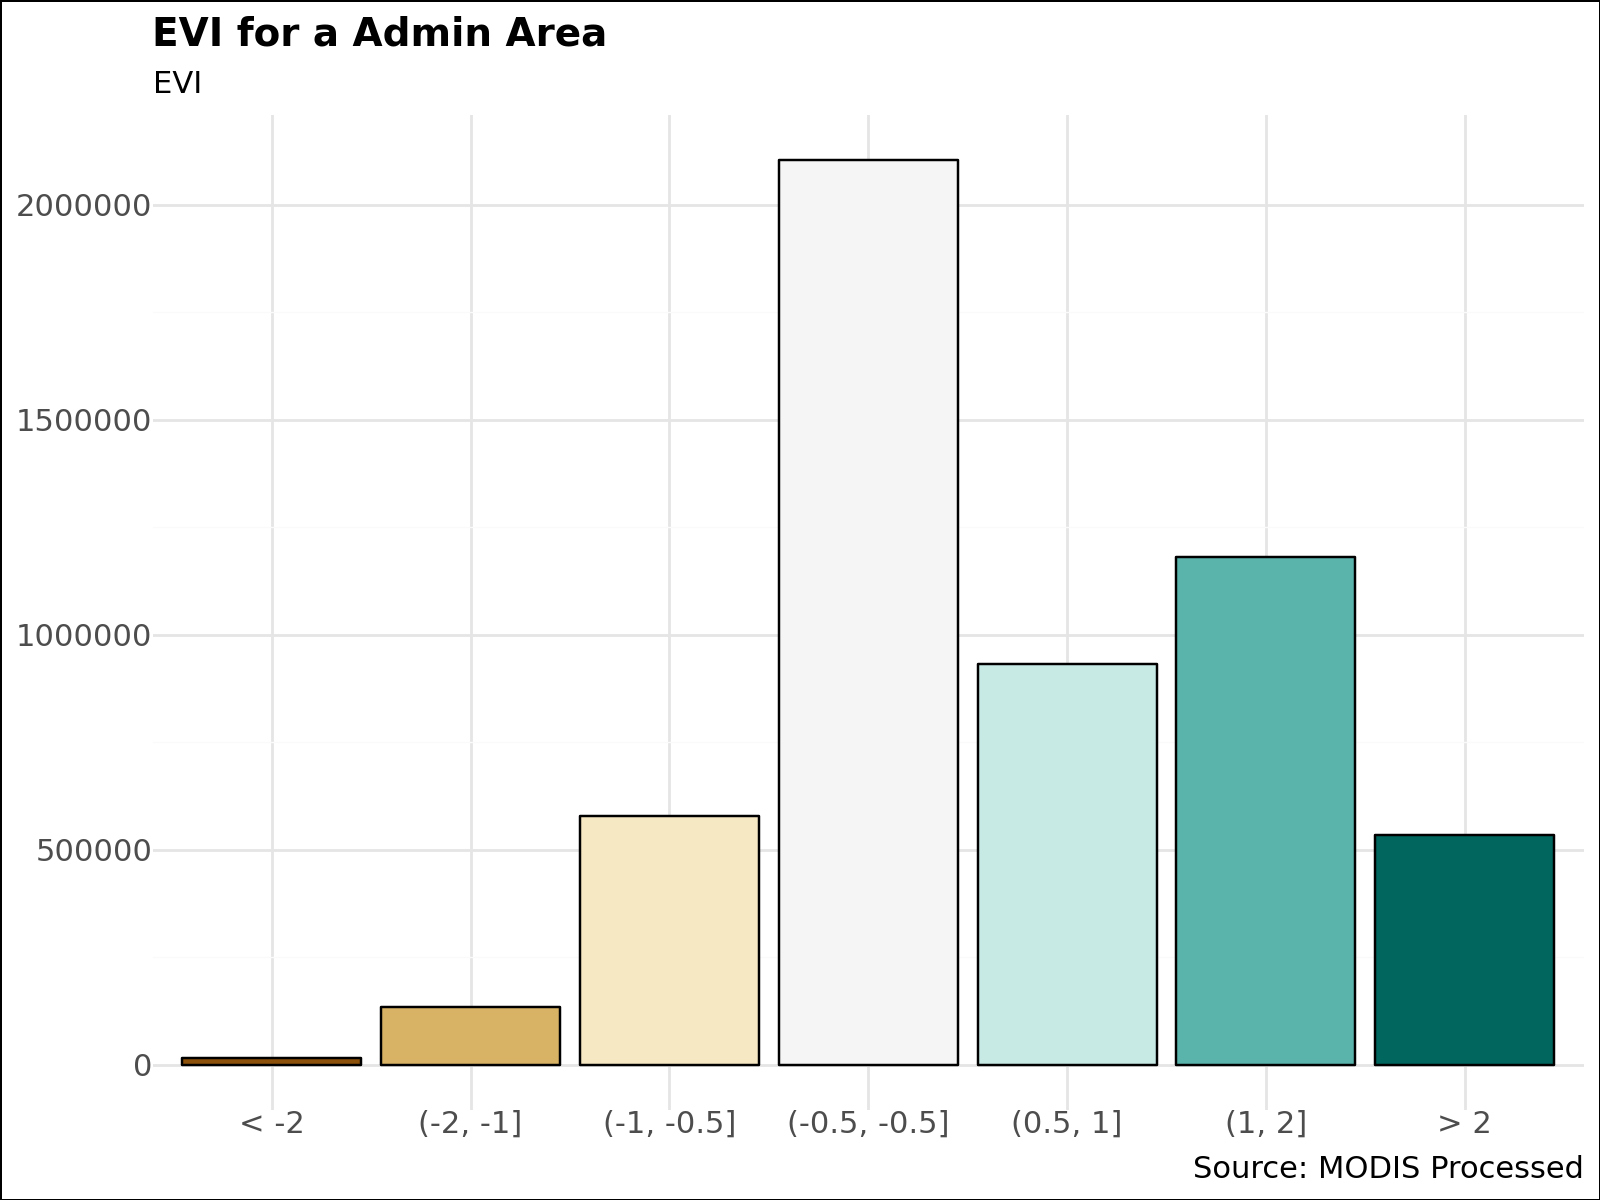

In [51]:
# fig, ax = plt.subplots()
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
from mizani.formatters import percent_format


(
    ggplot(df2, aes(x="zscore_bin", y="count", fill="zscore_bin"))
    + geom_bar(alpha=1, stat="identity", color="black")  #  fill='#006d2c'
    + labs(
        x="",
        subtitle="EVI",
        title="EVI for a Admin Area",
        y="",
        caption="Source: MODIS Processed",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none",
    )
    + scale_fill_brewer(type="div", palette="BrBG", direction=1)
    # + scale_fill_brewer(type='div', palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

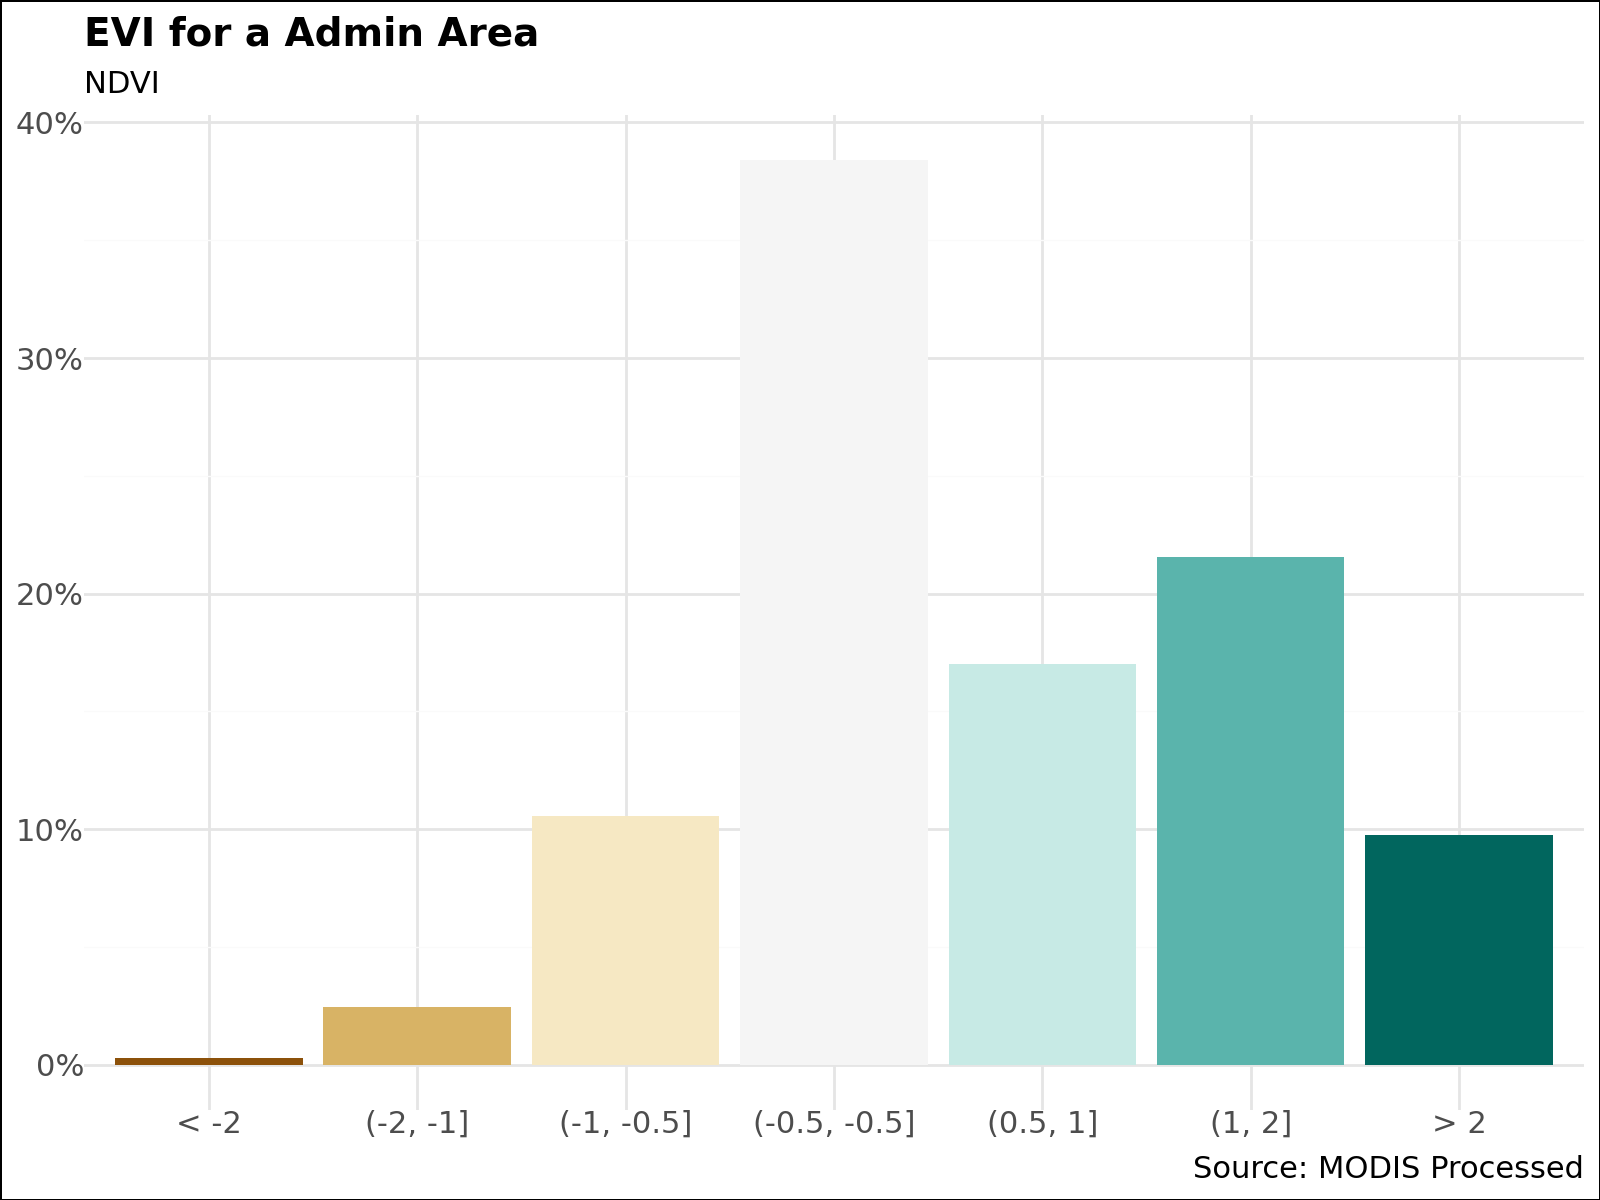

In [52]:
(
    ggplot(df2, aes(x="zscore_bin", y="pct", fill="zscore_bin"))
    + geom_bar(alpha=1, stat="identity")  #  fill='#006d2c'
    + labs(
        x="",
        subtitle="NDVI",
        title="EVI for a Admin Area",
        y="",
        caption="Source: MODIS Processed",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none",
    )
    + scale_fill_brewer(type="div", palette="BrBG", direction=1)
    # + scale_fill_brewer(type='div', palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

In [53]:
bins = [-20, -1, 1, 20]
bin_labels = ["< -1", "(-1, 1]", "> 1"]

df = pd.DataFrame(data, columns=["zscore"])
df.loc[:, "zscore_bin"] = pd.cut(
    data, bins=bins, include_lowest=True, labels=bin_labels
)
df2 = df["zscore_bin"].value_counts().sort_index()
df2 = pd.DataFrame(df2).reset_index()
df2.loc[:, "pct"] = df2["count"] / df2["count"].sum()

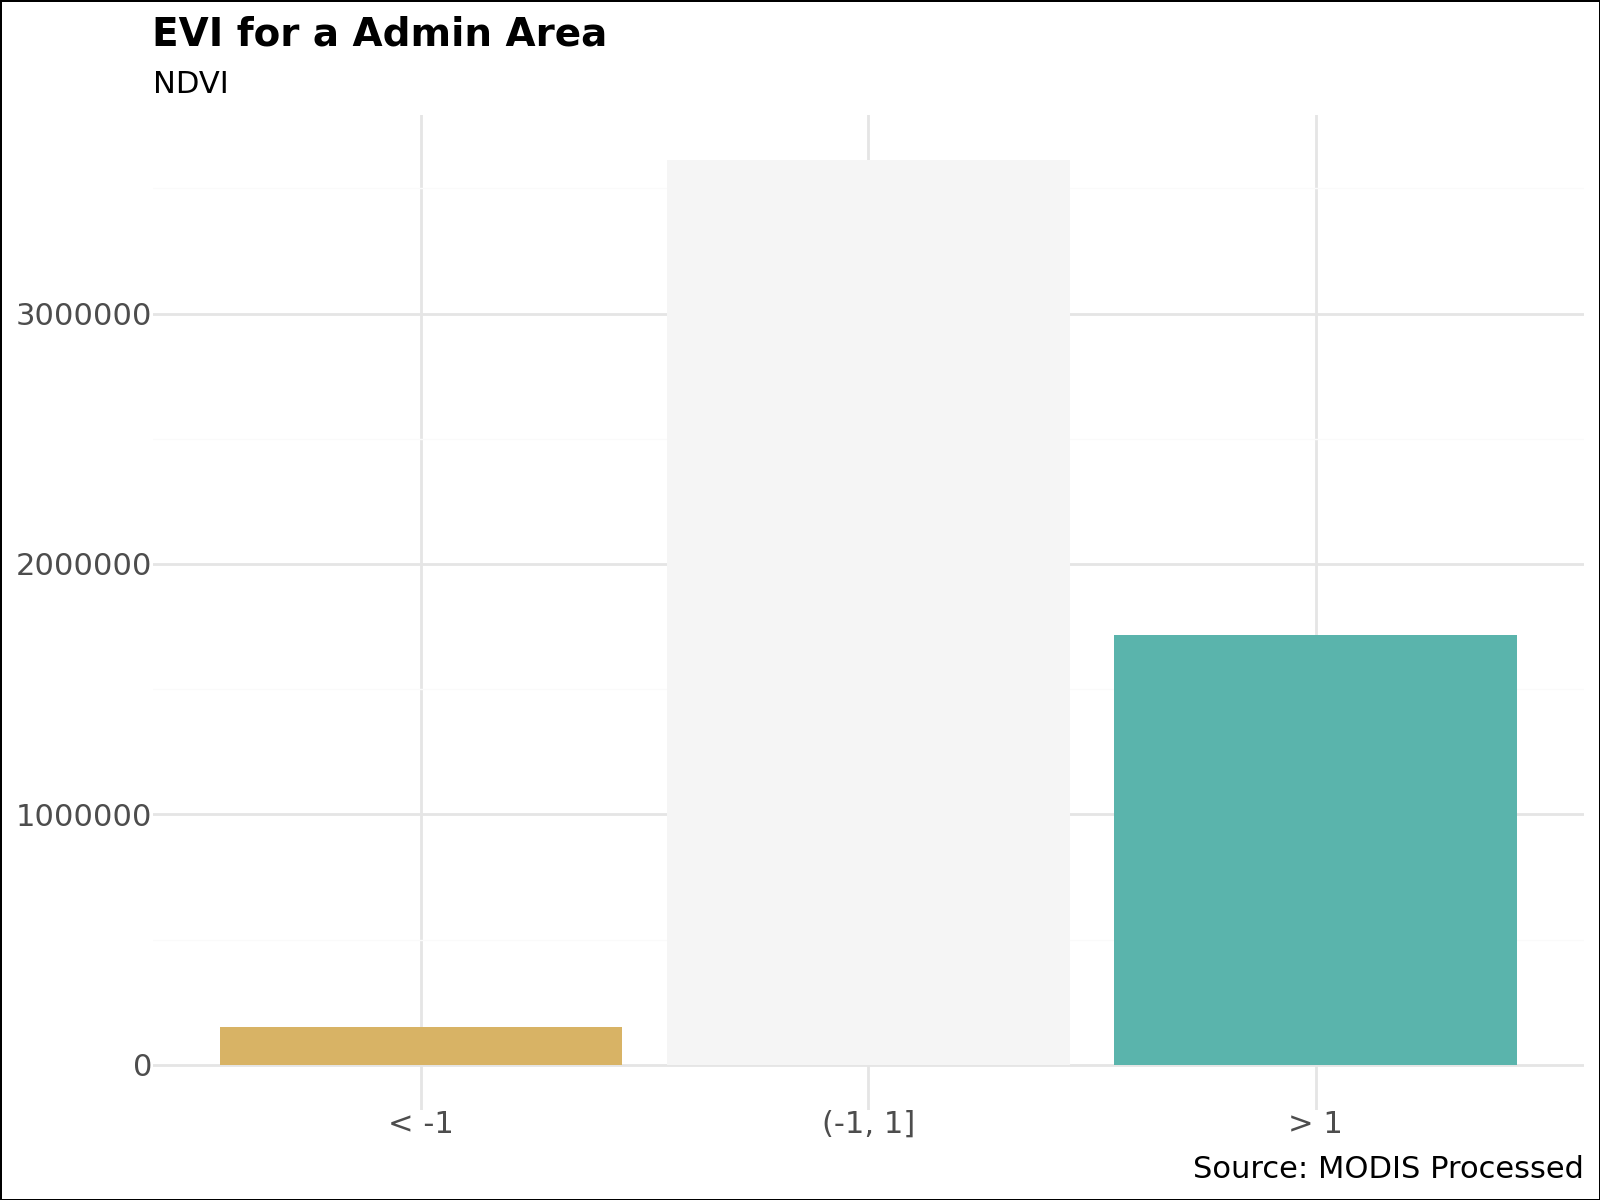

In [54]:
# fig, ax = plt.subplots()

(
    ggplot(df2, aes(x="zscore_bin", y="count", fill="zscore_bin"))
    + geom_bar(alpha=1, stat="identity")  #  fill='#006d2c'
    + labs(
        x="",
        subtitle="NDVI",
        title="EVI for a Admin Area",
        y="",
        caption="Source: MODIS Processed",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none",
    )
    + scale_fill_brewer(type="div", palette="BrBG", direction=1)
    # + scale_fill_brewer(type='div', palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

In [55]:
start_reference = "2010-01-01"
end_reference = "2022-12-31"

In [56]:
ds_ref = ds_monthly.sel(time=slice(None, end_reference))  # ds_geo
ds_ref_03_mean = ds_ref.sel(time=ds_ref.time.dt.month == 3).mean(dim="time")
ds_ref_03_sdt = ds_ref.sel(time=ds_ref.time.dt.month == 3).std(dim="time")


# ds_filt = ds_monthly.sel(time=ds_monthly.time.dt.year==2023)
# ds_2023_09 = ds_filt.sel(time=ds_filt.time.dt.month==9).isel(time=0)
# ds_diff = ds_2023_09 - ds_ref_09_mean
# ds_zscore = (ds_diff / ds_ref_09_sdt)

In [57]:
os.getcwd()

'/root'

In [58]:
res = []
years = range(2014, 2025)
for year in tqdm(years):
    print(f"Calc anomalies for {year}")
    ds_filt = ds_monthly.sel(time=ds_monthly.time.dt.year == year)
    ds_filt_03 = ds_filt.sel(time=ds_filt.time.dt.month == 3).isel(time=0)
    ds_diff = ds_filt_03 - ds_ref_03_mean
    ds_zscore = ds_diff / ds_ref_03_sdt
    ds_zscore = ds_zscore.compute()
    ds_zscore["veg_index"].rio.write_nodata(np.nan, inplace=True)
    #ds_zscore["veg_index"].rio.to_raster(f"zcore_dea_{year}_03.tif")
    data = ds_zscore["veg_index"].values
    data = data[~np.isnan(data)]
    res.append(data)

  0%|          | 0/11 [00:00<?, ?it/s]

Calc anomalies for 2014
Calc anomalies for 2015
Calc anomalies for 2016
Calc anomalies for 2017
Calc anomalies for 2018
Calc anomalies for 2019
Calc anomalies for 2020
Calc anomalies for 2021
Calc anomalies for 2022
Calc anomalies for 2023
Calc anomalies for 2024


In [59]:
bins = [-20, -2, -1, 1, 2, 20]
bin_labels = ["< -2", "(-2, -1]", "(-1, 1]", "(1, 2]", "> 2"]

In [60]:
res2 = []
for i, year in enumerate(years):
    data = res[i]
    df = pd.DataFrame(data, columns=["zscore"])
    df.loc[:, "zscore_bin"] = pd.cut(
        data, bins=bins, include_lowest=True, labels=bin_labels
    )
    df = df["zscore_bin"].value_counts().sort_index()
    df = pd.DataFrame(df).reset_index()
    df.loc[:, "pct"] = df["count"] / df["count"].sum()
    df.loc[:, "year"] = year
    # df.rename(columns={'count':f'count_{year}', 'pct': f'pct_{year}'}, inplace=True)
    res2.append(df)

In [61]:
df = pd.concat(res2, axis=0)

In [62]:
df.loc[:, "zscore_bin_cat"] = pd.Categorical(
    df["zscore_bin"], categories=bin_labels, ordered=True
)

In [63]:
df.zscore_bin_cat.value_counts()

zscore_bin_cat
< -2        11
(-2, -1]    11
(-1, 1]     11
(1, 2]      11
> 2         11
Name: count, dtype: int64

In [64]:
font = "Liberation Sans"

In [65]:
df.head()

,zscore_bin,count,pct,year,zscore_bin_cat
0,< -2,40027,0.007316,2014,< -2
1,"(-2, -1]",536116,0.097990,2014,"(-2, -1]"
2,"(-1, 1]",3770976,0.689253,2014,"(-1, 1]"
3,"(1, 2]",703549,0.128594,2014,"(1, 2]"
4,> 2,420435,0.076846,2014,> 2


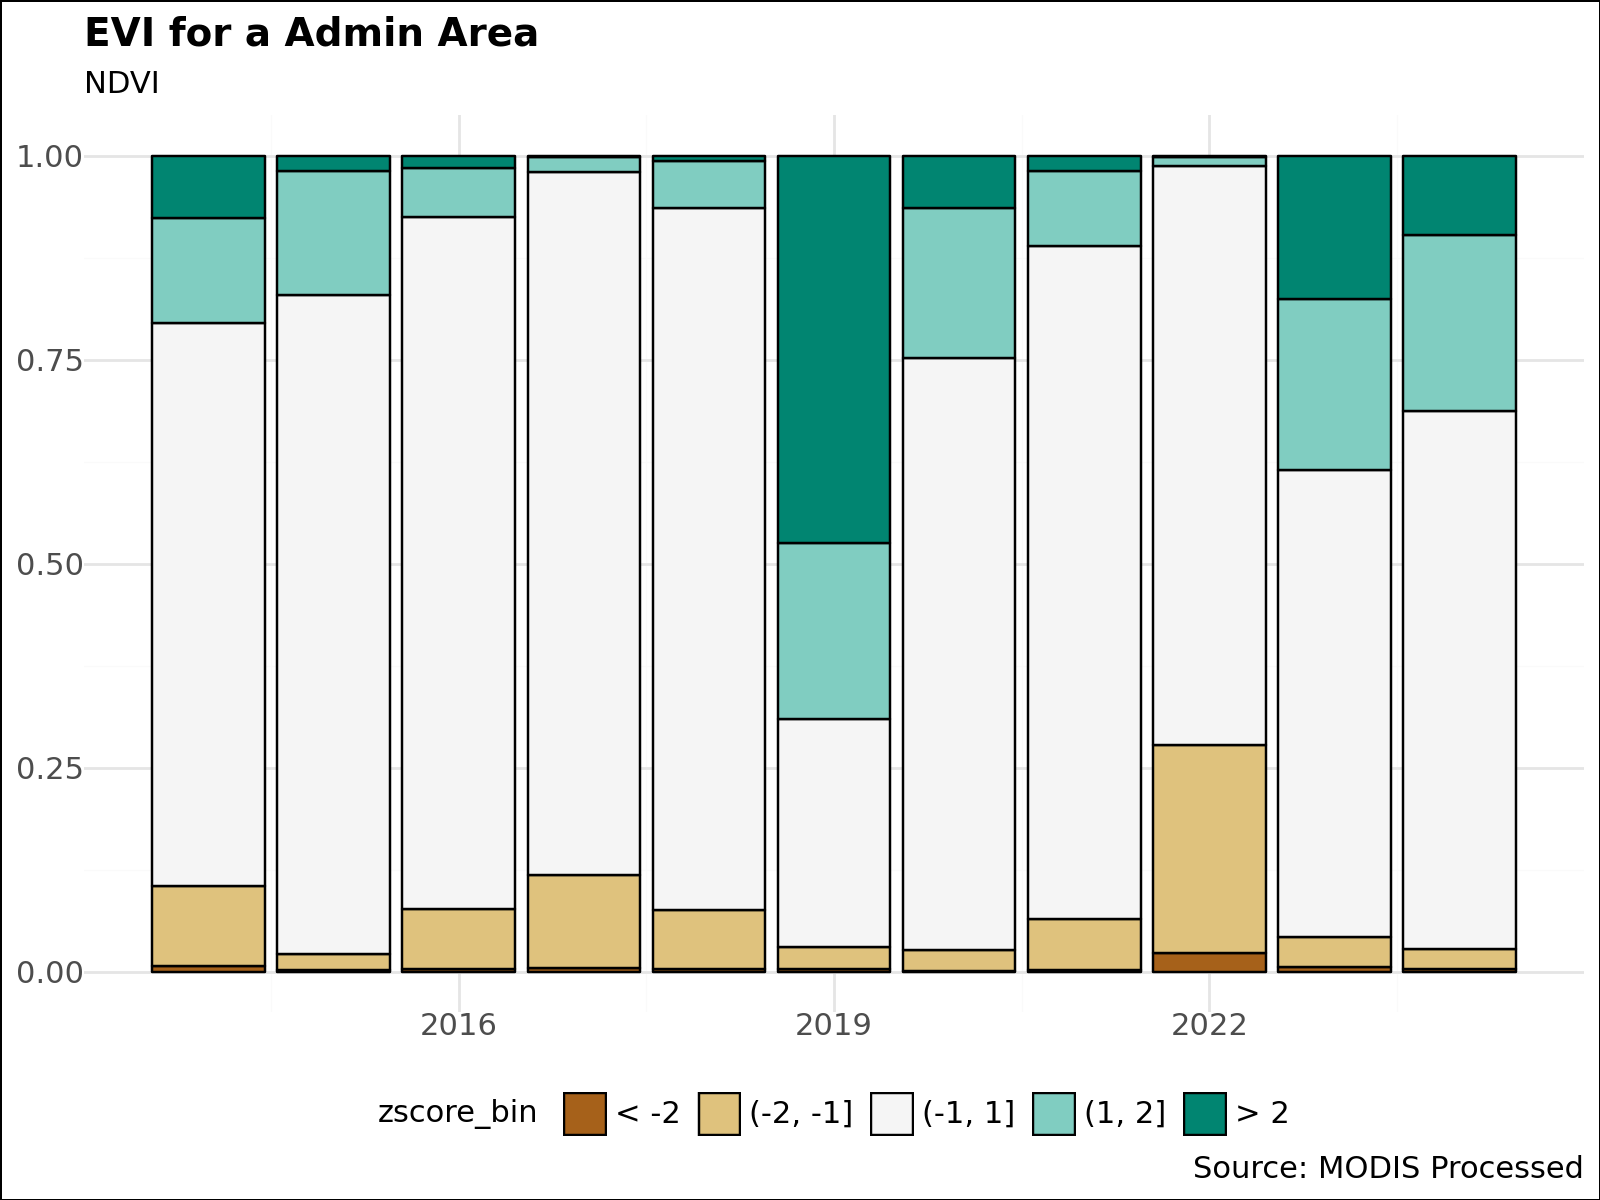

In [66]:
# fig, ax = plt.subplots()
(
    ggplot(df, aes(x="year", y="pct", fill="zscore_bin"))
    + geom_bar(
        alpha=1, stat="identity", color="black", position=position_fill(reverse=True)
    )  #  fill='#006d2c'
    + labs(
        x="",
        subtitle="NDVI",
        title="EVI for a Admin Area",
        y="",
        caption="Source: MODIS Processed",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none",
    )
    + scale_fill_brewer(type="div", palette="BrBG", direction=1)
    # + scale_fill_brewer(type='div', palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    # + scale_y_continuous(labels=percent_format())
    + theme(legend_position="bottom")
)

In [67]:
# fig, ax = plt.subplots()
p = (
    ggplot(df, aes(x="year", y="pct", fill="zscore_bin"))
    + geom_bar(
        alpha=1,
        stat="identity",
        color="black",
        width=0.5,
        position=position_fill(reverse=True),
    )  #  fill='#006d2c'
    + labs(
        x="",
        subtitle="% of Crop Area",
        title="Anomalies in Agricultural Productivity (EVI)",
        y="",
        caption="Source: MODIS Terra and Aqua",
        fill="Z-Score",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="bottom",
    )
    + scale_fill_brewer(type="div", palette="BrBG", direction=1)
    + coord_flip()
    + scale_y_continuous(labels=percent_format())
    + scale_x_continuous(breaks=range(2014, 2025))
    # + scale_fill_brewer(type='div', palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)
# p
#p.save(
    #filename=os.path.join(base_path, 'docs','images',"evi-anomalies-pct.jpeg"),
    #dpi=300,
#)

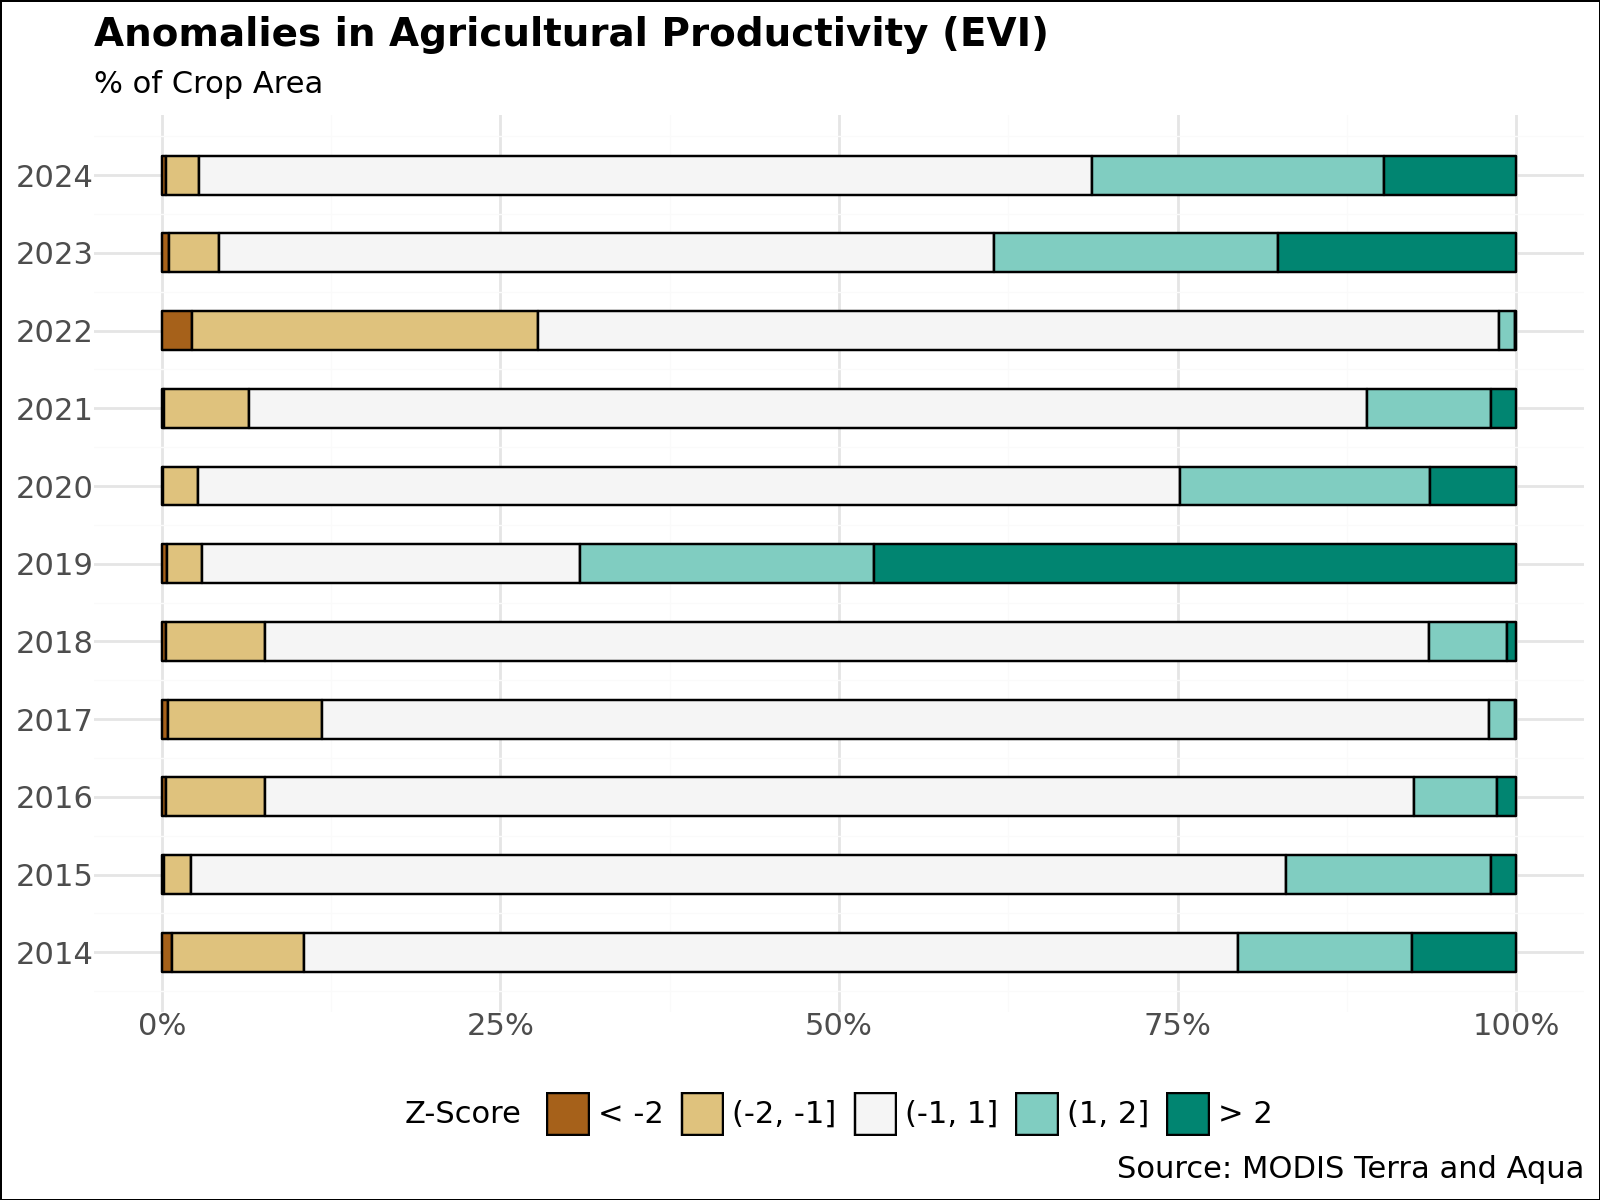

In [69]:
p